# ProductHunt Analysis (part 1)

### TL;DR

**Question 1**: What is the best day of the week to hunt/post a product?

Inconclusive. There is no magic day to hunt or post.

But there _is_ statistically significant differences between some of the days of the week though, for example:
1. Projects posted during the week (Monday-Friday) _do_ have, on average, more **comments** per project than the other days. Also, most products are posted on Tuesday, Wednesday, and Thursday.
2. Projects posted on Tuesday, Wednesday, and Thursday, on average, have more **makers** than projects posted on the other days.
3. There is no significant difference in average number of **upvotes** per project across the week.

So, those above are the facts. #1 and #2 are interesting, and they could be explained in many different ways, such as:
1. Maybe there is more _website traffic_ on Tuesday, Wednesday, Thursday which causes these observations.
2. Maybe the projects which are posted on Tuesday, Wednesday, Thursday are of higher quality thus attract more comments.
3. Maybe both.
4. Maybe neither.

We'll have to do more digging to answer this question more deeply.

**Question 2**: What time of day is best to hunt/post a product?

Conclusive! You should post at NIGHT! It can be seen that historical projects which were posted at night performed statistically significantly better both in number of comments and number of upvotes compared to projects posted in the MORNING, AFTERNOON, or EVENING.

If for some reason you can't post at NIGHT, then you should post in the MORNING instead.

Also, the vast majority of projects are posted at NIGHT or in the MORNING, so this finding is by no means novel, but at least it does give strong support to those who already do it. :P

**Want more detail?**

Below is the nitty-gritty detail, for those who care. :)

In [1]:
import numpy as np

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_info_columns', -1)
pd.set_option('display.max_info_rows', -1)

from scipy.stats import ttest_ind, f_oneway

import graphviz    # http://graphviz.readthedocs.io/en/latest/manual.html
from graphviz import Digraph, Graph

%matplotlib inline

We will be _good_ Data Scientists (Statisticians) and set our alpha cutoff level before beginning our experimentations. We'll set a low alpha cutoff because we really don't want type-I errors (false positives).

In [2]:
ALPHA_CUTOFF = 0.01

# Load the Data

In [3]:
topics = pd.read_csv('producthunt-product-hunt-research/AllTopics.csv')

In [ ]:
topics.head()

In [ ]:
topics.info(True)

In [5]:
posts = pd.read_csv('producthunt-product-hunt-research/PostsForAnalysis.csv',
                    parse_dates=['date', 'created_at'], infer_datetime_format=True)

In [6]:
# Fix the NaNs which appear in all the catorory columns.
category_cols = range(12, 313)
posts.iloc[:,category_cols] = posts.iloc[:,category_cols].fillna(False).astype(bool)

In [ ]:
posts.head()

In [ ]:
posts.info(True)

# Question 1: What is the best day of the week to hunt/post a product?

Before we can answer this question, we must explore the data some and answer a few sub-questions.

Below shows that the largest number of posts happen on {Tuesday, Wednesday, Thursday}, next most is on {Monday, Friday}, and least number of posts happen on the weekend {Saturday, Sunday}.

In [7]:
posts['day'].value_counts()

Tuesday      3596
Wednesday    3591
Thursday     3357
Monday       2507
Friday       2497
Saturday     1335
Sunday       1246
Name: day, dtype: int64

Next, let's look at how these days compare to one another on the basis of:
1. 'comments_count' -- The average number of comments per product
2. 'num_makers' -- The average number of people involved in making each product
3. 'num_topics' -- The average number of topics labeled per product
4. 'votes_count' -- The average number of "up-votes" per product

Let's see the average of these columns for each of our groups (days-of-the-week):

In [8]:
cols_of_interest = ['day', 'comments_count', 'num_makers', 'num_topics', 'votes_count']
day_stats = posts[cols_of_interest].groupby('day').apply(lambda x: np.mean(x))
day_stats

,comments_count,num_makers,num_topics,votes_count
day,,,,
Friday,12.489788,1.329996,2.990388,194.495795
Monday,13.351416,1.282409,3.000000,205.341444
Saturday,9.890637,1.035955,3.008240,196.095880
Sunday,10.070626,0.998395,3.001605,193.729535
Thursday,14.431040,1.730712,3.076259,217.222520
Tuesday,14.624305,1.583704,3.130423,214.841769
Wednesday,13.954052,1.552771,3.056252,207.918964


That's all well-and-good. Looks like there might be some interesting differences here, so let's next find out which of these groups are statistically significantly difference from one another based on each of these fields.

### Sub-question 1: Is there a statistically significant difference in average number of COMMENTS per product between the days of the week?

As a very first step, let's visualize the distribution of avg comments for each day of the week and see if we can see anything with our human eyes.

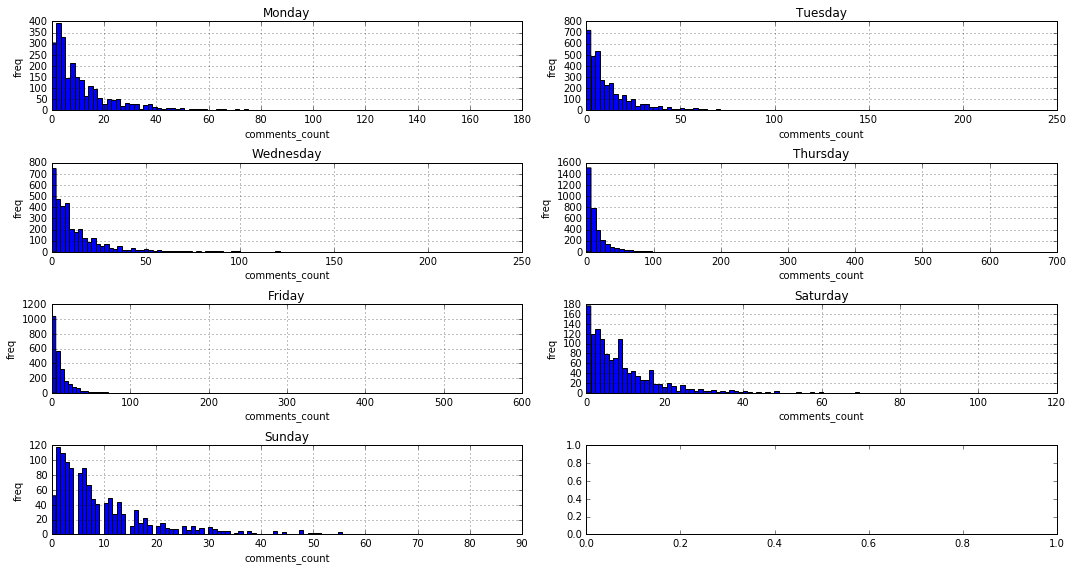

In [9]:
def plot_group_distributions(posts, group_column, group_column_values, response_column):
    fig, axes = plt.subplots((len(group_column_values)+1)/2, 2, figsize=(15, 8))
    for group, ax in zip(group_column_values, axes.flatten()):
        ax.set_title(group)
        posts[posts[group_column] == group][response_column].hist(bins=100, ax = ax)
        ax.set_ylabel('freq')
        ax.set_xlabel(response_column)
        #ax.set_xlim(0, 100)
    fig.tight_layout()

days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
plot_group_distributions(posts, 'day', days, 'comments_count')

These look very similar, really... let's turn to classical statistics to help us find which of these distributions have different means.

We'll start with a [one-way ANOVA](https://en.wikipedia.org/wiki/One-way_analysis_of_variance) test which will tell us if the means of different groups differ. In this case, the groups are the days of the week.

In [10]:
def one_way_anova(posts, group_column, group_column_values, response_column):
    samples_list = [posts[posts[group_column] == val][response_column] \
                    for val in group_column_values]
    res = f_oneway(*samples_list)
    print 'SIGNIFICANT' if res.pvalue < ALPHA_CUTOFF else 'not significant'
    return res

one_way_anova(posts, 'day', days, 'comments_count')

SIGNIFICANT


F_onewayResult(statistic=18.450175708395506, pvalue=1.7000044628943987e-21)

**Conclusion:** The answer to this question is "yes". That is, yes, there is a difference in the average number of comments per product between the 7 days of the week in which a product can be posted. That begs the next question: **_Which_ days of the week differ significantly based on the average number of COMMENTS per product?**

To answer this question, we'll use a [post-hoc test](https://en.wikipedia.org/wiki/Post_hoc_analysis) (essentially a t-test over each pair of days, again looking at the number of comments per product). We'll be very conservative here and do the [Bonferroni correction](https://en.wikipedia.org/wiki/Post_hoc_analysis#The_Bonferroni_procedure).

The code below runs the post-hoc test. In the graph below, an edge denotes that two day do *not* have significantly different avg number of comments.

number of hypotheses (Bonferroni denominator): 21.0
adjusted alpha: 0.00047619047619
edges below denote NOT significant


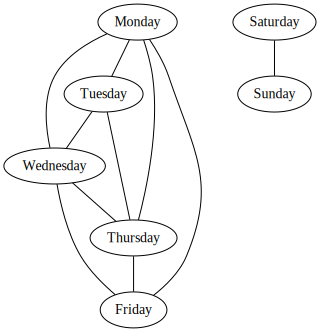

In [11]:
def post_hoc_test_with_bonferroni(posts, group_column, group_column_values, response_column):
    m = len(group_column_values) * (len(group_column_values)-1) / 2.
    print 'number of hypotheses (Bonferroni denominator):', m
    print 'adjusted alpha:', ALPHA_CUTOFF/m
    print 'edges below denote NOT significant'

    graph = Graph()
    for g in group_column_values:
        graph.node(g)

    for i, g1 in enumerate(group_column_values):
        for g2 in group_column_values[i+1:]:
            a = posts[posts[group_column] == g1][response_column]
            b = posts[posts[group_column] == g2][response_column]
            res = ttest_ind(a, b, equal_var=False)
            if res.pvalue >= ALPHA_CUTOFF/m:
                graph.edge(g1, g2)

    return graph   # calls ._repr_svg_(), also see .render()

post_hoc_test_with_bonferroni(posts, 'day', days, 'comments_count')

**Conclusion**: The distinct groups are "weekdays" vs "weekends". We can very safely conclude that more comments are made per product when the product is posted on a weekday instead of a weekend.

Next, let's see if we can figure out (speculate about) _why_ this is.

Candidate reasons:
1. Maybe there are more users visiting ProductHunt.com during the week, causing more comments per product during the week.
2. Maybe the product posted during the week draw more comments (possibly they are higher quality products) than those products posted on the weekend.

### Sub-question 2: Is there a statistically significant difference in average number of MAKERS between the days of the week?

We'll use the same method as before, first visualize the distributions, then do a one-way ANOVA, followed by a post-hoc test.

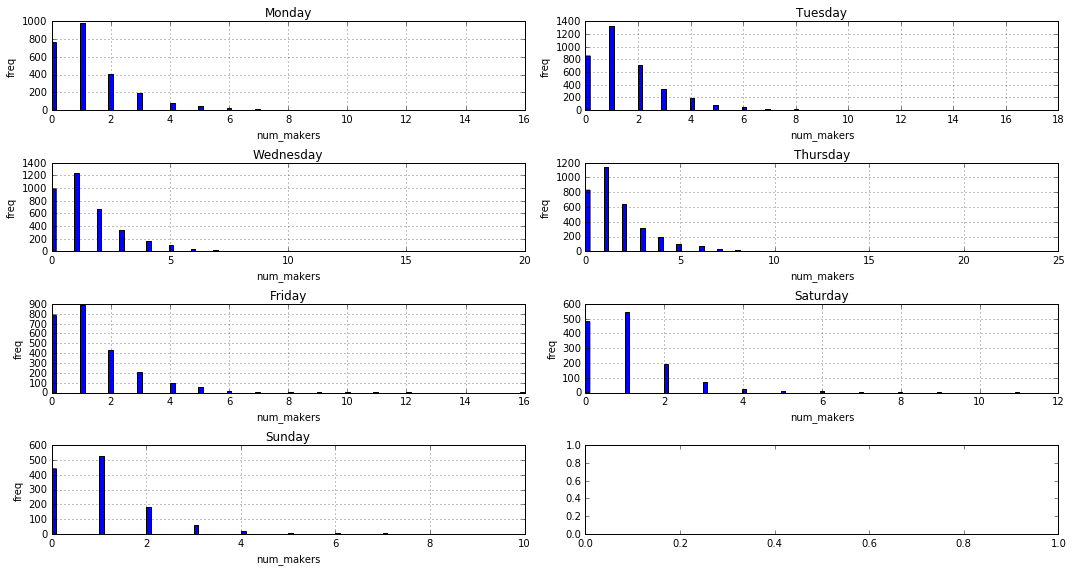

In [12]:
plot_group_distributions(posts, 'day', days, 'num_makers')

In [13]:
one_way_anova(posts, 'day', days, 'num_makers')

SIGNIFICANT


F_onewayResult(statistic=61.160471302490279, pvalue=2.112114785652092e-75)

number of hypotheses (Bonferroni denominator): 21.0
adjusted alpha: 0.00047619047619
edges below denote NOT significant


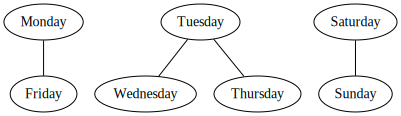

In [14]:
post_hoc_test_with_bonferroni(posts, 'day', days, 'num_makers')

**Conclusion**: Yikes! Three groups have arisen. Seems like {Tuesday, Wednesday, Thursday} have significantly more MAKERS per product! Next is {Monday, Friday}. And lastly, {Saturday, Sunday} have the least number of MAKERS per product. This is very interesting. To summarize: _Teams_ seem to post mid-week. _Lone Wolves_ seem to post on the weekends (speculation -> this makes some sense if these lone wolves are working on a for-fun project in their spare time on the weekends).

### Sub-question 3: Is there a statistically significant difference in average number of TOPICS between the days of the week?

We'll use the same method as before, first visualize the distributions, then do a one-way ANOVA, followed by a post-hoc test.

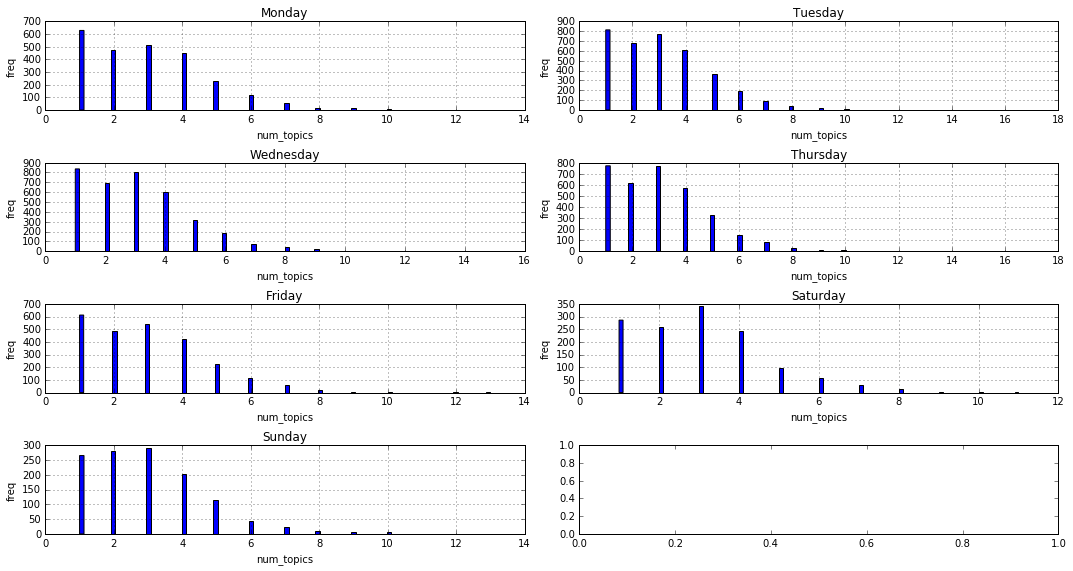

In [15]:
plot_group_distributions(posts, 'day', days, 'num_topics')

In [16]:
one_way_anova(posts, 'day', days, 'num_topics')

not significant


F_onewayResult(statistic=2.3800603204226514, pvalue=0.026697365211464867)

number of hypotheses (Bonferroni denominator): 21.0
adjusted alpha: 0.00047619047619
edges below denote NOT significant


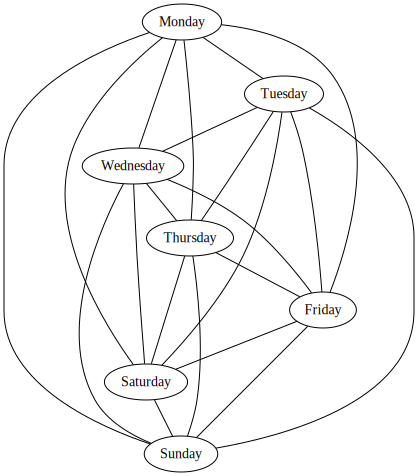

In [17]:
post_hoc_test_with_bonferroni(posts, 'day', days, 'num_topics')

**Conclusion**: This turned out not interesting. The number of topics does not significantly differ over the days of the week.

### Sub-question 4: Is there a statistically significant difference in average number of VOTES between the days of the week?

We'll use the same method as before, first visualize the distributions, then do a one-way ANOVA, followed by a post-hoc test.

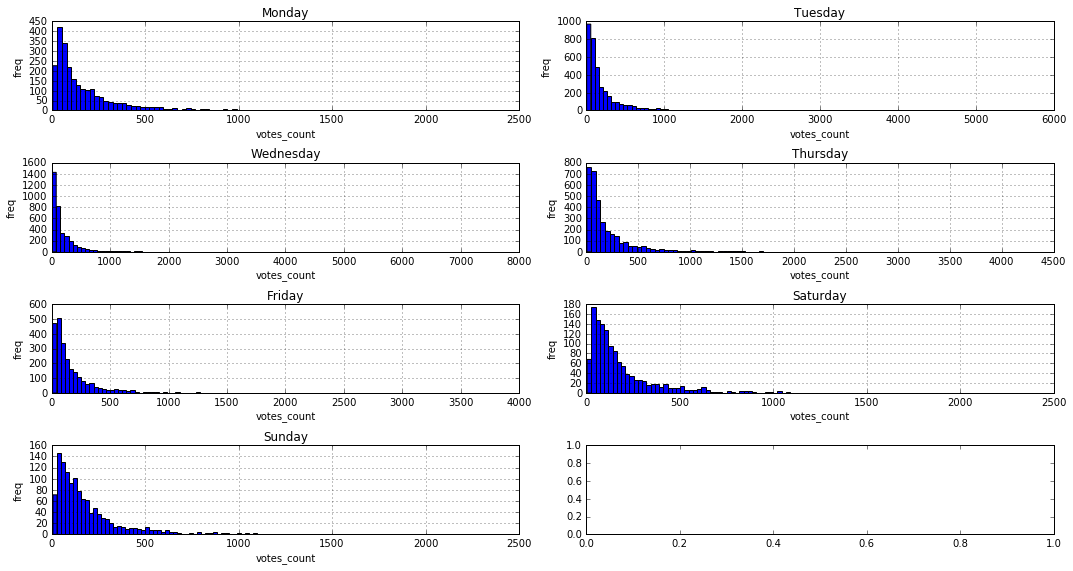

In [18]:
plot_group_distributions(posts, 'day', days, 'votes_count')

In [19]:
one_way_anova(posts, 'day', days, 'votes_count')

not significant


F_onewayResult(statistic=2.7274826470137525, pvalue=0.011949950993141088)

number of hypotheses (Bonferroni denominator): 21.0
adjusted alpha: 0.00047619047619
edges below denote NOT significant


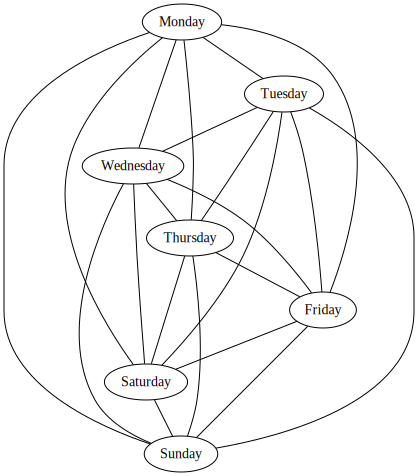

In [20]:
post_hoc_test_with_bonferroni(posts, 'day', days, 'votes_count')

**Conclusion**: This turned out not interesting. The number of votes does not significantly differ over the days of the week.

### What are we now?

We still haven't answered the main question: What is the best day of the week to hunt/post a product?

But we have revealed a few things. To review, we know that:
1. Products get (on average) more comments on weekdays vs weekends.
2. _Team_ projects (projects with more makers per project than average) tend to be posted on Tuesday, Wednesday, Thursday. _Lone Wolf_ project tend to be posted on the weekends.
3. The average number of topics per project does not change over the week.
4. The average number of upvotes per project does not change over the week.

All this taken together, I would suspect that #1 above is probably caused by #2 above. But that's only speculation, of course. Nonetheless, the most interesting find is #2 above -- why do teams tend to post mid-week? Anyone have any ideas for ways to get to the bottom of that? Let's move on for now, however.

# Question 2: What time of day is best to hunt/post a product?

We'll follow the exact same procedure to answer this questions (rather, to begin digging into this question) as we did for Question 1.

You can see below that most projects are posted in at NIGHT or in the MORNING.

In [21]:
posts['time_of_day'].value_counts()

Night        9250
Morning      8028
Afternoon    724 
Evening      127 
Name: time_of_day, dtype: int64

Let's get our summary statistics about these four new groups. At first glance, the conclusion looks pretty obvious: NIGHT wins. But we'll be sure to check for statistical significance to be sure.

In [22]:
cols_of_interest = ['time_of_day', 'comments_count', 'num_makers', 'num_topics', 'votes_count']
day_stats = posts[cols_of_interest].groupby('time_of_day').apply(lambda x: np.mean(x))
day_stats

,comments_count,num_makers,num_topics,votes_count
time_of_day,,,,
Afternoon,5.790055,0.653315,1.953039,98.303867
Evening,3.094488,0.370079,1.629921,63.149606
Morning,11.142501,1.415172,2.742277,179.048206
Night,15.947784,1.552757,3.423459,241.670811


### Is there a statistically significant difference in average number of COMMENTS per product between the posting's time of day?

Again, we'll follow our normal approach: visualize the distributions, do a one-way ANOVA followed by a ad-hoc test.

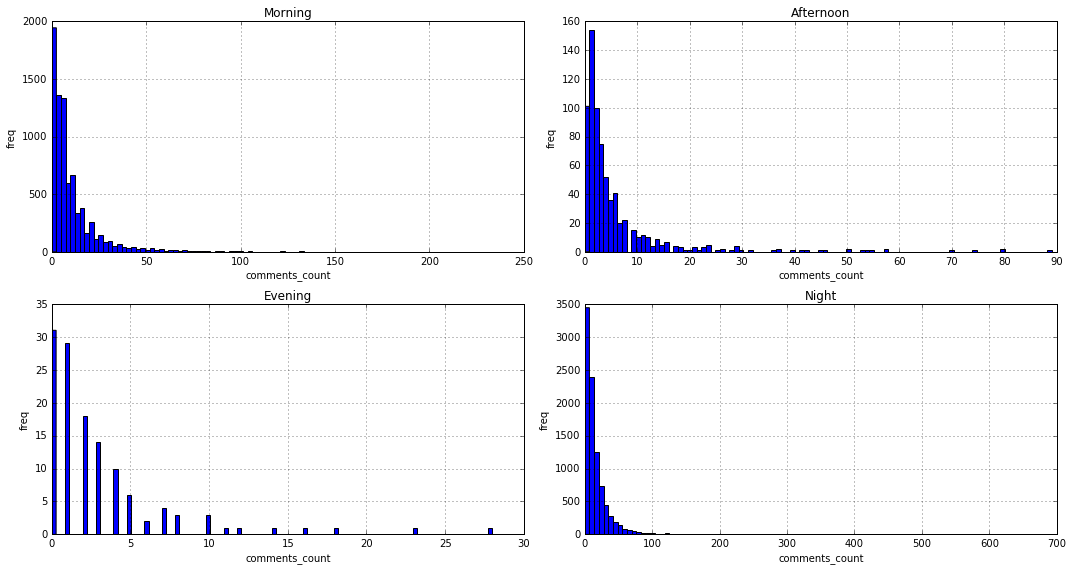

In [23]:
times = ['Morning', 'Afternoon', 'Evening', 'Night']
plot_group_distributions(posts, 'time_of_day', times, 'comments_count')

In [24]:
one_way_anova(posts, 'time_of_day', times, 'comments_count')

SIGNIFICANT


F_onewayResult(statistic=138.6764912718202, pvalue=7.7478558140432792e-89)

number of hypotheses (Bonferroni denominator): 6.0
adjusted alpha: 0.00166666666667
edges below denote NOT significant


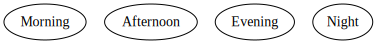

In [25]:
post_hoc_test_with_bonferroni(posts, 'time_of_day', times, 'comments_count')

### Is there a statistically significant difference in average number of MAKERS per product between the posting's time of day?

Again, we'll follow our normal approach: visualize the distributions, do a one-way ANOVA followed by a ad-hoc test.

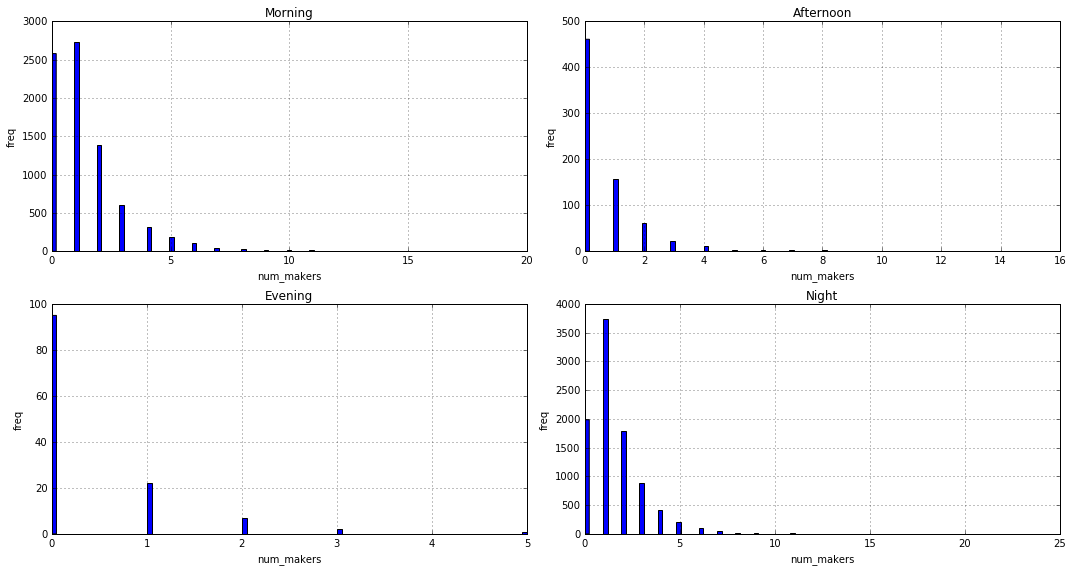

In [26]:
plot_group_distributions(posts, 'time_of_day', times, 'num_makers')

In [27]:
one_way_anova(posts, 'time_of_day', times, 'num_makers')

SIGNIFICANT


F_onewayResult(statistic=91.028808776559117, pvalue=1.8229409020870447e-58)

number of hypotheses (Bonferroni denominator): 6.0
adjusted alpha: 0.00166666666667
edges below denote NOT significant


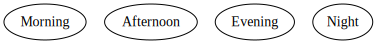

In [28]:
post_hoc_test_with_bonferroni(posts, 'time_of_day', times, 'num_makers')

### Is there a statistically significant difference in average number of TOPICS per product between the posting's time of day?

Again, we'll follow our normal approach: visualize the distributions, do a one-way ANOVA followed by a ad-hoc test.

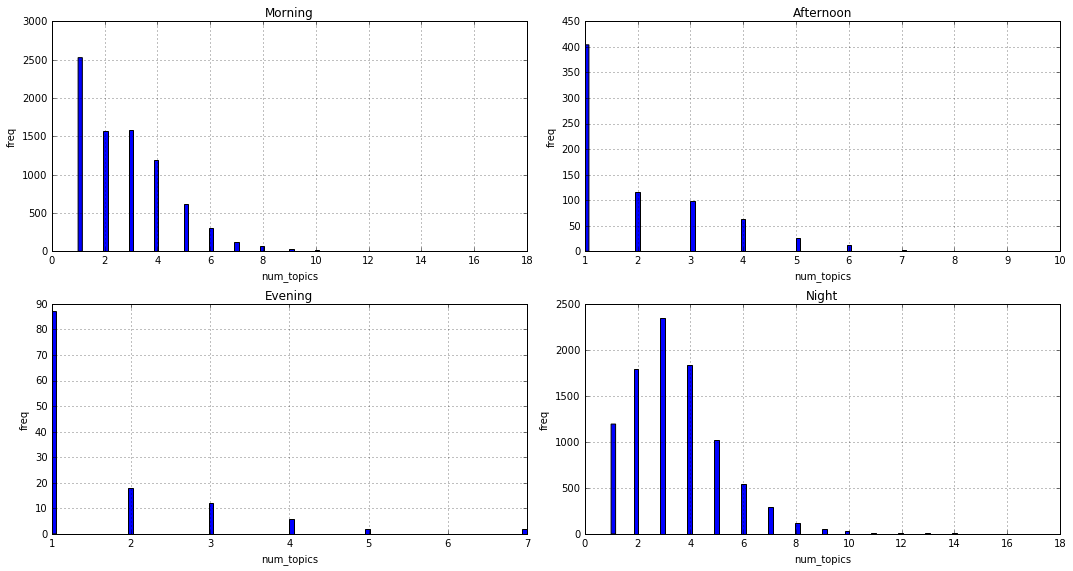

In [29]:
plot_group_distributions(posts, 'time_of_day', times, 'num_topics')

In [30]:
one_way_anova(posts, 'time_of_day', times, 'num_topics')

SIGNIFICANT


F_onewayResult(statistic=346.76205103810372, pvalue=5.6023079288452679e-219)

number of hypotheses (Bonferroni denominator): 6.0
adjusted alpha: 0.00166666666667
edges below denote NOT significant


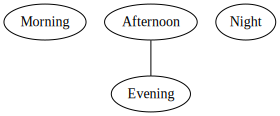

In [31]:
post_hoc_test_with_bonferroni(posts, 'time_of_day', times, 'num_topics')

### Is there a statistically significant difference in average number of VOTES per product between the posting's time of day?

Again, we'll follow our normal approach: visualize the distributions, do a one-way ANOVA followed by a ad-hoc test.

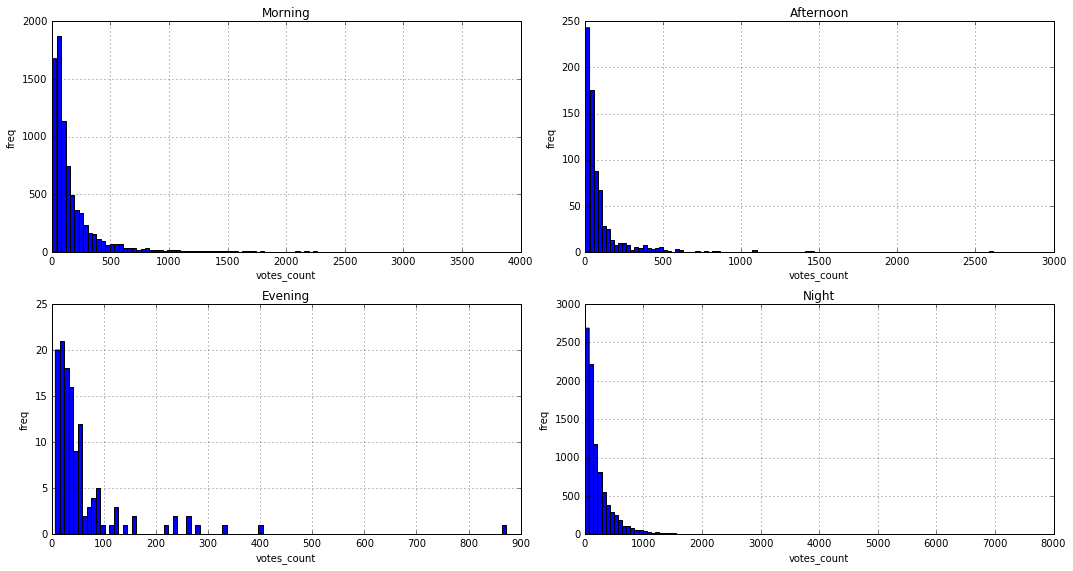

In [32]:
plot_group_distributions(posts, 'time_of_day', times, 'votes_count')

In [33]:
one_way_anova(posts, 'time_of_day', times, 'votes_count')

SIGNIFICANT


F_onewayResult(statistic=117.58048019161772, pvalue=2.04980701835799e-75)

number of hypotheses (Bonferroni denominator): 6.0
adjusted alpha: 0.00166666666667
edges below denote NOT significant


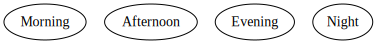

In [34]:
post_hoc_test_with_bonferroni(posts, 'time_of_day', times, 'votes_count')